In [3]:
%pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [11]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from sklearn.metrics import accuracy_score, f1_score

/opt/anaconda3/envs/LLMs/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
set_seed(42)
FAST = True  # Limitare la data

In [5]:
dataset = load_dataset("ag_news")

split = dataset["train"].train_test_split(test_size=0.3, seed=42)
train_valid = split["train"]
val_test = split["test"].train_test_split(test_size=0.5, seed=42)

train_ds = train_valid
valid_ds = val_test["train"]
test_ds  = val_test["test"]

if FAST:
    train_ds = train_ds.shuffle(seed=42).select(range(1000))
    valid_ds = valid_ds.shuffle(seed=42).select(range(200))
    test_ds  = test_ds.shuffle(seed=42).select(range(200))

print(f"Train: {len(train_ds)}, Valid: {len(valid_ds)}, Test: {len(test_ds)}")

label_names = ["World", "Sports", "Business", "Sci/Tech"]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Train: 1000, Valid: 200, Test: 200


In [7]:
from transformers import AutoTokenizer

def tokenize_dataset(dataset, model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    def preprocess(batch):
        return tokenizer(
            batch["text"],
            truncation=True,
            padding="max_length",
            max_length=128
        )

    dataset_tokenized = dataset.map(preprocess, batched=True)
    dataset_tokenized.set_format(
        "torch",
        columns=["input_ids", "attention_mask", "label"]
    )
    return dataset_tokenized, tokenizer

In [8]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro")
    }

def train_and_eval(model_name, train_ds, valid_ds, test_ds, epochs=1):
    # Tokenización
    train_tok, tokenizer = tokenize_dataset(train_ds, model_name)
    valid_tok, _ = tokenize_dataset(valid_ds, model_name)
    test_tok, _  = tokenize_dataset(test_ds,  model_name)

    # Cargar modelo preentrenado
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=4
    )

    # Argumentos de entrenamiento
    args = TrainingArguments(
        output_dir=f"./{model_name.replace('/', '_')}_out",
        eval_strategy="epoch",              # En versiones >=5.0
        save_strategy="no",
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=epochs,
        weight_decay=0.01,
        logging_dir="./logs",
        report_to="none"
    )

    # Entrenador
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_tok,
        eval_dataset=valid_tok,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    # Entrenamiento
    trainer.train()

    # Evaluación final en test
    test_metrics = trainer.predict(test_tok).metrics
    print(f"{model_name} test results: {test_metrics}")

    return {
        "Model": model_name,
        "F1": test_metrics["test_f1_macro"],
        "Accuracy": test_metrics["test_accuracy"]
    }

In [9]:
models = [
    "distilroberta-base",
    "microsoft/deberta-v3-small",
    "answerdotai/ModernBERT-base"
]

results = []
for m in models:
    print(f"Training model: {m}")
    res = train_and_eval(
        m,
        train_ds,
        valid_ds,
        test_ds,
        epochs=1 if FAST else 2
    )
    results.append(res)

df_results = pd.DataFrame(results)
df_results

Training model: distilroberta-base


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4193280596.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,0.383909,0.855000,0.851829


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


distilroberta-base test results: {'test_loss': 0.4162381887435913, 'test_accuracy': 0.88, 'test_f1_macro': 0.8803740971523248, 'test_runtime': 42.7913, 'test_samples_per_second': 4.674, 'test_steps_per_second': 0.584}
Training model: microsoft/deberta-v3-small


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/286M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4193280596.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


model.safetensors:   0%|          | 0.00/286M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,0.701100,0.725000,0.662465


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


microsoft/deberta-v3-small test results: {'test_loss': 0.7181970477104187, 'test_accuracy': 0.755, 'test_f1_macro': 0.7358994983000933, 'test_runtime': 57.5813, 'test_samples_per_second': 3.473, 'test_steps_per_second': 0.434}
Training model: answerdotai/ModernBERT-base


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4193280596.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': None, 'bos_token_id': None}.
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,0.470645,0.855000,0.850991


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


answerdotai/ModernBERT-base test results: {'test_loss': 0.49496662616729736, 'test_accuracy': 0.815, 'test_f1_macro': 0.8146333455480295, 'test_runtime': 119.2637, 'test_samples_per_second': 1.677, 'test_steps_per_second': 0.21}


,Model,F1,Accuracy
0,distilroberta-base,0.880374,0.880
1,microsoft/deberta-v3-small,0.735899,0.755
2,answerdotai/ModernBERT-base,0.814633,0.815


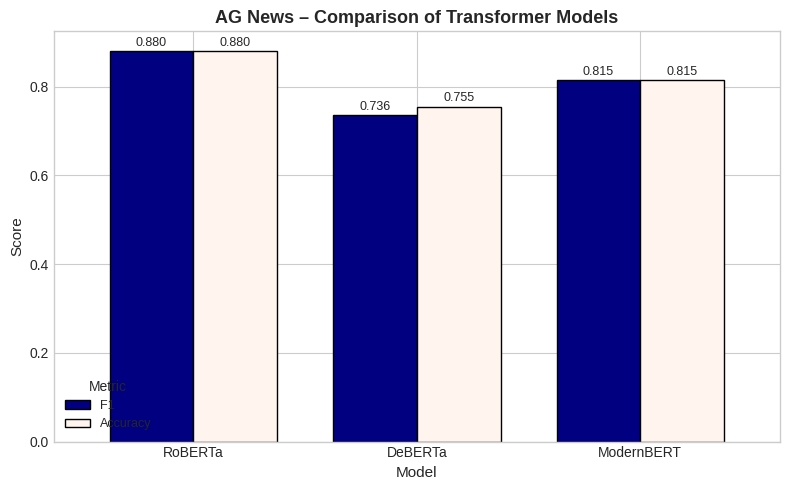

In [10]:
# Renombrar modelos para el gráfico
rename_map = {
    "distilroberta-base": "RoBERTa",
    "microsoft/deberta-v3-small": "DeBERTa",
    "answerdotai/ModernBERT-base": "ModernBERT"
}

df_results["Model_Short"] = df_results["Model"].replace(rename_map)

plt.style.use("seaborn-v0_8-whitegrid")

ax = df_results.set_index("Model_Short")[["F1", "Accuracy"]].plot(
    kind="bar",
    figsize=(8, 5),
    color=["#000080", "#FFF5EE"],
    edgecolor="black",
    width=0.75
)

# Configuración del gráfico
ax.set_title("AG News – Comparison of Transformer Models", fontsize=13, fontweight="bold")
ax.set_ylabel("Score", fontsize=11)
ax.set_xlabel("Model", fontsize=11)
ax.legend(title="Metric", fontsize=9, title_fontsize=10)

# Nombres normales y centrados en el eje X
ax.set_xticklabels(["RoBERTa", "DeBERTa", "ModernBERT"], rotation=0, fontsize=10)

# Etiquetas numéricas sobre cada barra
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.3f}",
        (p.get_x() + p.get_width() / 2, p.get_height() + 0.005),
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.tight_layout()
plt.show()

In [13]:
df = pd.read_csv("../data/rpp_llm_labels.csv")
df

,description_en,LLM_label
0,Kevin Quevedo received a hard blow just starte...,Sports
1,"In the afternoon, the General Commander of the...",World
2,Alianza Lima plays in Alejandro Villanueva aga...,Sports
3,"Rotaphon of RPP, Manuel Villena Ibáñez, who ha...",Sci/Tech
4,According to the proposal of the Parliamentary...,World
5,"After delaying his tour in Peru, Gian Marco re...",World
6,"In statements to RPP, Marcela Ríos, regional d...",Sci/Tech
7,What was the last Temblor in Chile today 16 Oc...,Sci/Tech
8,The People's Department one dead and more than...,World
9,Sigrid Bazán politically responsible the gover...,Sci/Tech


In [33]:
from transformers import pipeline
import pandas as pd

# Diccionario con nombres y rutas de los modelos
models = {
    "RoBERTa": "distilroberta-base",
    "DeBERTa": "microsoft/deberta-v3-small",
    "ModernBERT": "answerdotai/ModernBERT-base"
}

# Categorías posibles
label_names = ["World", "Sports", "Business", "Sci/Tech"]

In [34]:
def classify_with_model(model_name, column_name):
    clf = pipeline("text-classification", model=model_name, tokenizer=model_name)

    def predict_label(text):
        result = clf(str(text), truncation=True, max_length=128)[0]["label"]
        # Algunos modelos devuelven LABEL_0...3 → los convertimos a texto
        if result.startswith("LABEL_"):
            idx = int(result.split("_")[-1])
            return label_names[idx]
        return result

    df[column_name] = df["description_en"].apply(predict_label)
    print(f"Column '{column_name}' created using {model_name}")

In [35]:
for col, model in models.items():
    classify_with_model(model, f"{col}_label")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


Column 'RoBERTa_label' created using distilroberta-base


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Device set to use cpu


Column 'DeBERTa_label' created using microsoft/deberta-v3-small


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


Column 'ModernBERT_label' created using answerdotai/ModernBERT-base


In [36]:
from sklearn.metrics import accuracy_score, f1_score

results = []
for col in ["RoBERTa_label", "DeBERTa_label", "ModernBERT_label"]:
    acc = accuracy_score(df["LLM_label"], df[col])
    f1 = f1_score(df["LLM_label"], df[col], average="macro")
    results.append({"Model": col.replace("_label", ""), "Accuracy": acc, "F1": f1})

df_bonus = pd.DataFrame(results)
df_bonus

,Model,Accuracy,F1
0,RoBERTa,0.22,0.090164
1,DeBERTa,0.48,0.162162
2,ModernBERT,0.38,0.225000


Los tres modelos presentaron un rendimiento limitado, con métricas en general bajas debido a que fueron entrenados originalmente para otro tipo de clasificación, aun cuando las noticias de RPP se tradujeron al inglés para aproximar el dominio del conjunto AG News, parece que los modelos no lograron tener un buen desempeño.
Dentro de este contexto, DeBERTa mostró el mejor desempeño en accuracy, evidenciando una mayor capacidad para capturar relaciones contextuales(igual es un mal desempeño), RoBERTa fue el menos efectivo, lo que sugiere una menor generalización ante textos fuera de su dominio de entrenamiento.